In [2]:
import sys
import os

import cv2
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as patches

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense , Activation , Dropout ,Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.metrics import categorical_accuracy
from keras_vggface.vggface import VGGFace

project_path = os.path.abspath(os.path.join('../'))
if project_path not in sys.path:
    sys.path.append(project_path)
from utils.load_data import load_FER2013, parse_FER2013, load_CKPlus
from utils.plots import plot_face_with_label, plot_model_history, plot_generated_images
from models.models import simple_CNN, mini_Xception
# from utils.data_generator import init_resnet_generator, init_cnn_generator
from utils.preprocess import normalize_data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

checkpoint_path = '../models/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from keras_vggface import utils


In [4]:
train, val, test = load_FER2013(DATA_DIR)

MemoryError: Unable to allocate 32.2 GiB for an array with shape (28709, 224, 224, 3) and data type float64

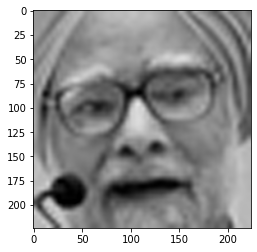

In [11]:
# img = np.fromstring(data.loc[idx, 'pixels'], dtype=int, sep=' ')


img = np.fromstring(train.loc[1, 'pixels'], dtype='uint8', sep=' ')
img = np.reshape(img, (48, 48))
img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC)
img = img[..., np.newaxis]
img = np.repeat(img, repeats=3, axis=-1)
plt.imshow(img)
img.nbytes

In [2]:
# Constants
DATA_DIR = '../data'
possible_emotions = ['anger', 'disgust', 'fear', 'happiness',
                    'sadness', 'surprise', 'neutral']
emotion_label_map = {'anger': 0, 'disgust': 1, 'fear': 2, 'happiness': 3,
                    'sadness': 4, 'surprise': 5, 'neutral': 6}

# train_data, val_data, test_data = load_FER2013(DATA_DIR)
# X_train, Y_train = parse_FER2013(train_data, target_size=(224, 224), target_channel=3)
# X_val, Y_val = parse_FER2013(val_data, target_size=(224, 224), target_channel=3)
# X_test, Y_test = parse_FER2013(test_data, target_size=(224, 224), target_channel=3)

MemoryError: Unable to allocate 4.03 GiB for an array with shape (3589, 224, 224, 3) and data type float64

In [20]:
def resnet_preprocess(x):
    x = cv2.resize(x, (224, 224), interpolation=cv2.INTER_CUBIC)
    x = x[..., np.newaxis]
    x = np.repeat(x, repeats=3, axis=-1)
    return x

def init_resnet_generator(data_dir, with_aug=True):
    if with_aug:
        data_generator = ImageDataGenerator(
            horizontal_flip=True,
            rotation_range=10,
            zoom_range=0.1,
            width_shift_range=0.1,
            height_shift_range=0.1,
            rescale=1./255
        )
    else:
        data_generator = ImageDataGenerator(rescale=1./255)
    return data_generator.flow_from_directory(
            data_dir,
            target_size=(224, 224),
            color_mode='rgb',
            shuffle=True,
            batch_size=64)

# class DataSequence(Sequence):
#     def __init__(self, X, Y, batch_size=64,
#                  target_dim=(224, 224), target_channels=3,
#                  shuffle=True):
#         assert len(X) == len(Y)
#         self.X = X
#         self.Y = Y
#         self.num_samples = len(Y)
#         self.batch_size = batch_size
#         self.target_dim = target_dim
#         self.shuffle = True
    
#     def __len__(self):
#         return int(self.num_samples / self.batch_size)
        
#     def __getitem__(self, idx):
#         indexes = self.indexes[idx * self.batch_size: (idx + 1) * self.batch_size]
#         X = np.zeros((self.batch_size, *self.target_dim, self.target_channels))
#         for i, idx in enumerate(indexes):
#             x = self.X[idx]
#             x = cv2.resize(x, self.target_dim, interpolation=cv2.INTER_CUBIC)
#             x = self.gray2RGB(x)
#             X[i] = utils.preprocess_input(x, version=2)
#         return X, self.Y[indexes]

#     def gray2RGB(self, x):
#         if len(x.shape) == 2:
#             return np.stack((x, x, x), -1)
#         else:
#             assert len(x.shape) == 3
#             if x.shape[-1] == 1:
#                 return np.repeat(x, repeats=self.target_channels, axis=-1)
#             else:
#                 assert x.shape[-1] == 3
#         return x
    
#     def get_batch_Y(self, idx):
#         return self.Y[idx * self.batch_size: (idx + 1) * self.batch_size]
    
#     def on_epoch_end(self):
#         self.indexes = np.arange(self.num_samples)
#         if self.shuffle == True:
#             self.indexes = np.random.shuffle(self.indexes)
data_dir = '../data/fer/'
train_gen = init_resnet_generator(data_dir + 'train', with_aug=True)
val_gen = init_resnet_generator(data_dir + 'val', with_aug=False)
test_gen = init_resnet_generator(data_dir + 'test', with_aug=False)

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


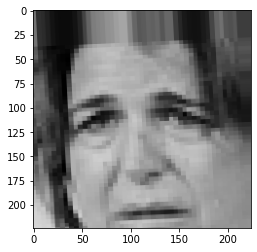

In [24]:
for e in train_gen:
    plt.imshow(e[0][0])
    break

In [25]:
from keras.optimizers import Adam

def resnet():
    resnet = VGGFace(model='resnet50', include_top=False, input_shape = (224,224,3))
    resnet.trainable = False
    model = Sequential([
        resnet,
        Flatten(),
        Dropout(0.25),
        Dense(2048, activation='relu'),
        Dropout(0.25),
        Dense(1024, activation='relu'),
        Dense(7, activation='softmax')
    ])
    opt = Adam(0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [29]:
model = simple_CNN()

In [30]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, verbose=1)
history = model.fit(train_gen,
                    epochs=50, batch_size=64,
                    validation_data=val_gen,
                    shuffle=True,
                    callbacks=[cp_callback])

Epoch 1/50


UnimplementedError:  Fused conv implementation does not support grouped convolutions for now.
	 [[node sequential_1/conv2d/Relu (defined at <ipython-input-30-7f1116c41e44>:2) ]] [Op:__inference_train_function_10312]

Function call stack:
train_function


In [12]:
test_preds = m.predict(X_test).argmax(axis=1)
acc = (test_preds == np.argmax(Y_test, axis=1)).mean()
loss, acc = m.evaluate(X_test, Y_test)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

113/113 [==============================] - 2s 12ms/step - loss: 0.9371 - accuracy: 0.6615
Restored model, accuracy: 66.15%


In [43]:
fer_model.save('../models/')
fer_model.save('../saved_models/mini_Xception-0.61.h5')


INFO:tensorflow:Assets written to: ../models/assets


In [16]:
m = keras.models.load_model('../models/saved_models/fer2013_simple_CNN-e88-a0.65.hdf5')

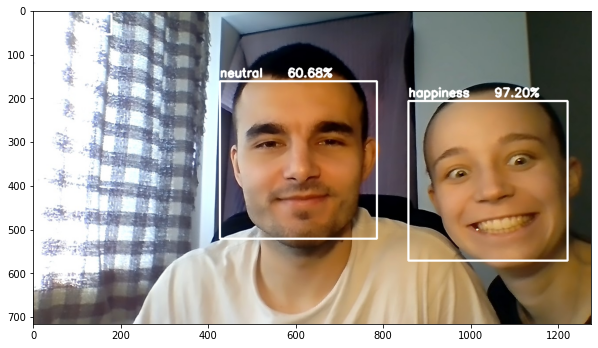

In [39]:
faceCascade = cv2.CascadeClassifier()
faceCascade.load(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
my_face = cv2.imread(DATA_DIR + '/my_face.jpg')
gray = cv2.cvtColor(my_face, cv2.COLOR_BGR2GRAY)
faces = faceCascade.detectMultiScale(
    gray,
    scaleFactor=1.1,
    minNeighbors=5,
    minSize=(30, 30)
)
plt.figure(figsize=(10,10))
for face in faces:
    x, y, w, h = face
    face = gray[y: y+h, x: x+w]
    face = cv2.resize(face, (48, 48))
    face = np.expand_dims(face, axis=0)
    face = np.expand_dims(face, axis=-1)
    predictions = m.predict(face/255)
    pred = np.argmax(predictions)
    prob = predictions[0, pred] * 100
    image = cv2.rectangle(my_face, (x, y), (x + w, y + h), (255,255,255), 4)
    cv2.putText(image, possible_emotions[pred] + f'    {prob:.2f}%', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,255,255), 3)
plt.imshow(image[:,:,::-1])

In [ ]:
plot_face_with_label(image, faces[0], FER_labels[pred])
print(my_face.shape)

print(face.shape)
plt.imshow(face)

In [ ]:
pred = np.argmax(predictions)
predictions * 100

In [ ]:
FER_labels[pred]

In [ ]:
vgg16 = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(48, 48, 1),
    classifier_activation="softmax",
)

In [5]:
history = {'accuracy': np.random.randn(10), 'val_accuracy': np.random.randn(10),
'loss': np.random.randn(10), 'val_loss':np.random.randn(10)}

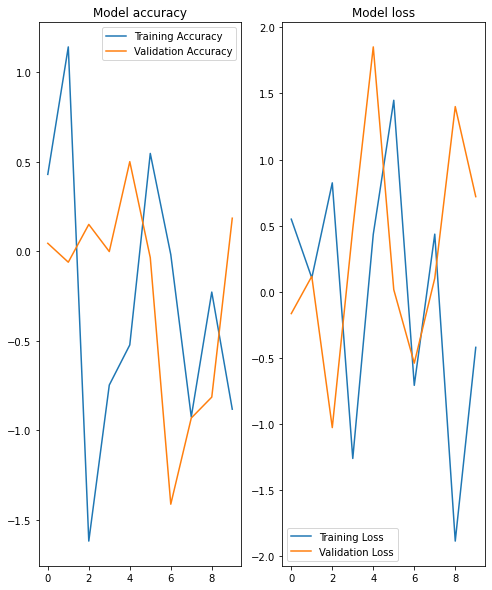

In [6]:
plot_model_history(range(10), history)

In [6]:
my_face = cv2.imread(DATA_DIR + '/my_face.jpg')
my_face = cv2.cvtColor(my_face, cv2.COLOR_BGR2GRAY)

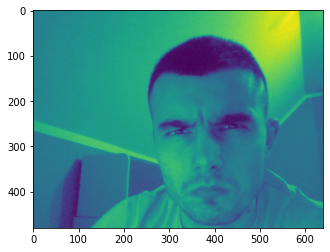

In [8]:
plt.imshow(my_face)

In [12]:
x = random_channel_shift(my_face, 0.2)

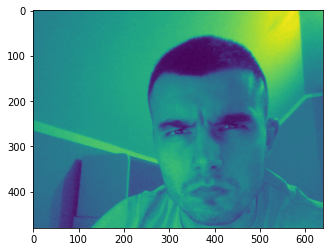

In [14]:
plt.imshow(x)

In [20]:
x_train_FER.info()

AttributeError: 'numpy.ndarray' object has no attribute 'info'